In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from dataclasses import replace
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from loguru import logger

from utils.omen_utils import load_data_into_omen_dataset
from omen import OMEN

logger.remove()
logger.add(sys.stderr, level=1);


In [25]:
omen_ds = load_data_into_omen_dataset(1, downsample_movements_factor=4)

# omen_ds.sessions[0] = omen_ds.sessions[0].trim(25, sampler='random')
# print(f"After trimming: {omen_ds.sessions[0].n_train_trials} trials")

# omen_ds.sessions[0].test_trials = [omen_ds.sessions[0].train_trials[0]]
# omen_ds.sessions[0].validation_trials = [omen_ds.sessions[0].train_trials[0]]
# print(omen_ds.sessions[0].X_train.shape)


# _, ax = omen_ds.sessions[0].visualize();
# ax.set(xlim=[0, 1e5]);

2024-07-30 15:32:04.045 | DEBUG    | utils.omen_utils:load_data_into_omen_dataset:87 - Found 20 training paths and 0 validation paths


Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left


2024-07-30 15:32:04.564 | DEBUG    | utils.omen_utils:ds_to_session:37 - Creating session alex_kovalev_standart_elbow_left


Reorder this dataset alex_kovalev_standart_elbow_left True


2024-07-30 15:32:04.769 | DEBUG    | utils.omen_utils:load_data_into_omen_dataset:100 - Added session alex_kovalev_standart_elbow_left with 94 trials and 11750 samples (470.00 seconds)


# Train OMEN

Train OMEN

In [26]:
# omen_config = dict(
#     activation= 'leaky_relu',
#     beta= 2.5,
#     embedding_dim= 64,
#     head_n_layers= 1,
#     input_sigma= 0.25,
#     kernel_size= 5,
#     lr= 0.0075,
#     n_epochs=500,
#     n_hidden= 64,
#     n_kernels= 1,
#     n_layers= 2,
#     sigma= 0.25,
# )
omen_config = {'n_hidden': 256,
            'n_layers': 1,
            'embedding_dim': 128,
            'activation': 'relu',
            'input_sigma': 0.1,
            'kernel_size': 5,
            'head_n_layers': 2,
            'lr': 0.00036,
            'n_epochs': 1500,
            'beta': 0.55,
            'sigma': 0.35,
            'n_kernels': 1,
            'N': 48,
            'patience': 500}

betas = [4, 8, 8, 4, 4, 4, 4, 4]
sigmas = [1, 1, 1, 1, 0.5, 1, 1, 0.5]

# create and fit
omen = OMEN.from_config(omen_config)
omen.fit_session(
    omen_ds.sessions[0], plot_history=True, verbose=True, should_refine=False
)

# refine CAN hps
# for i, (beta, sigma) in enumerate(zip(betas, sigmas)):
#     omen.cans[i].initial_params = {'beta': beta,
#           'sigma': sigma}
#     omen.cans[i].cell.tau = 1.2

# for can in omen.cans:
#     can.initial_params = {'beta': 8,
#           'sigma': 0.25}
#     can.cell.beta = 8

# omen.refine_cans(verbose=True)
omen

2024-07-30 15:32:13.598 | DEBUG_LOW | omen.omen:build:67 - Building OMEN - encoder input dimension: 8
2024-07-30 15:32:13.627 | DEBUG    | omen.omen:fit_session:249 - Fitting OMEN with a single session: alex_kovalev_standart_elbow_left
2024-07-30 15:32:13.630 | DEBUG_LOW | omen.lookup.lut:on_fit_start:90 - Fitting Y scalers on 11750 samples - 20 dimensions | 1 sessions
2024-07-30 15:32:13.641 | DEBUG_LOW | omen.lookup.session:populate:93 - Populating alex_kovalev_standart_elbow_left session lookup.
2024-07-30 15:32:13.837 | DEBUG    | omen.train.base_trainer:__init__:51 - 
Trainer SingleSessionTrainer created with 
LUT(n sessions: 1, embedding size: 256)
	* alex_kovalev_standart_elbow_left 
and
Portent
	Encoder: tCNN: 8 |> 256 |> 128 -  relu, 1 kernels, kernel_size: 5
	Heads:
		0: MLP: 128 |> 48 > 48 |> 48 - relu
		1: MLP: 128 |> 48 > 48 |> 48 - relu
		2: MLP: 128 |> 48 > 48 |> 48 - relu
		3: MLP: 128 |> 48 > 48 |> 48 - relu
		4: MLP: 128 |> 48 > 48 |> 48 - relu
		5: MLP: 128 |> 48 > 4

Output()

In [ ]:
# omen.predict_session(omen_ds.sessions[0], trial_set='train')
# omen_ds.sessions[0].visualize(max_n_trials=50);

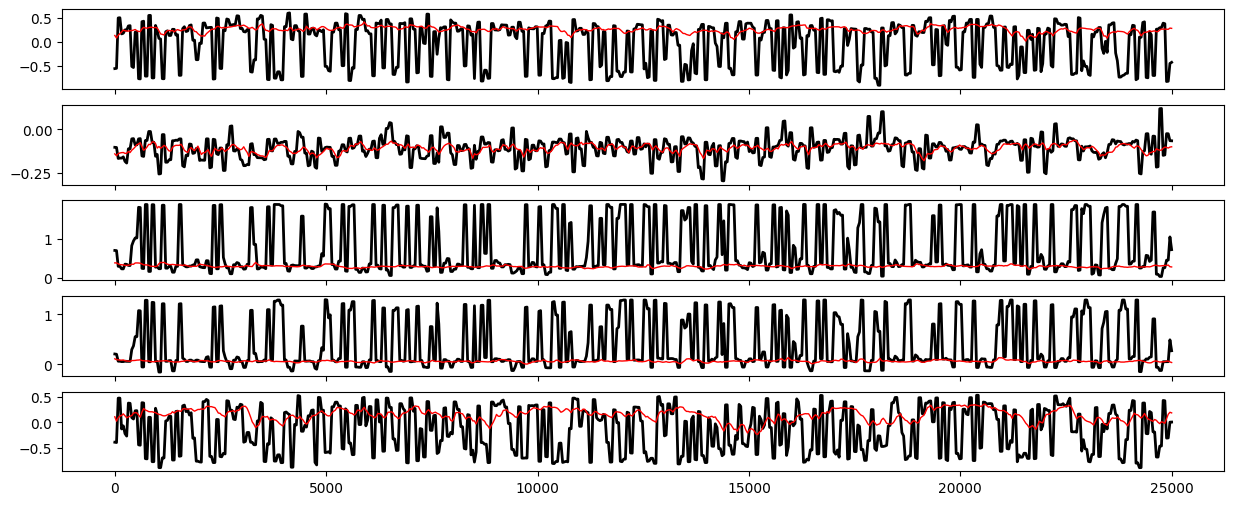

In [ ]:
n_to_plot=5


f, axes = plt.subplots(n_to_plot, 1, figsize=(15, 6), sharex=True)

starts = [trial.time[0] for trial in omen_ds.sessions[0].train_trials]
sorted_trials = [trial for _, trial in sorted(zip(starts, omen_ds.sessions[0].train_trials))]

for trial in sorted_trials[:5]:
    sd = omen.lut[omen_ds.sessions[0].name]
    trial.Ypred = omen.predict(
        sd.on_predict_start(
                        trial.X, do_ue=False
                    )
    )

    for i in range(n_to_plot):
        axes[i].plot(trial.time, trial.Y[:, i], label='true', color='k', lw=2)
        axes[i].plot(trial.time, trial.Ypred[:, i], label='pred', color='r', lw=1)
